# Urban Sound Multiclass Classifier
### ML1020 - Machine Learning at Scale

## Data Analysis

Let's load the train data and explore available classes and sample distirubtion between the classes. note: the test data is not labled thus it is useless for the training purpose. We have no choice but employ the train dataset to train and validate the model.

### Sound Classes

In [94]:
# improt required lbraries
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import IPython.display
import soundfile as sf
import glob
import random

# define the path relative to the notebook source
# expected data structure
# -----------------------------------------------
# project root
# src
#   main.ipynb
# data
#   original
#     train
#       samples
#         *.wav
#       train.csv
#     test
#       samples
#         *.wav
#       test.csv
TRAIN_DATA_PATH = "../data/original/train"
TRAIN_FILE = "train.csv"
# Read the train data classification info 
classification = pd.read_csv("{0}/{1}".format(TRAIN_DATA_PATH,TRAIN_FILE),sep = ',')

In [95]:
classification.head(10)

,ID,Class
0,0,siren
1,1,street_music
2,2,drilling
3,3,siren
4,4,dog_bark
5,6,children_playing
6,10,street_music
7,11,drilling
8,12,gun_shot
9,15,dog_bark


In [96]:
classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5435 entries, 0 to 5434
Data columns (total 2 columns):
ID       5435 non-null int64
Class    5435 non-null object
dtypes: int64(1), object(1)
memory usage: 85.0+ KB


Let's examine what classes are available

In [97]:
classes = classification.Class.unique()
classes

array(['siren', 'street_music', 'drilling', 'dog_bark',
       'children_playing', 'gun_shot', 'engine_idling', 'air_conditioner',
       'jackhammer', 'car_horn'], dtype=object)

In [98]:
print("Number of classes: {0}".format(len(classes)))

Number of classes: 10


As per the output above the dataset comprises ten urban sound classes. It is time to take a look at the class population.

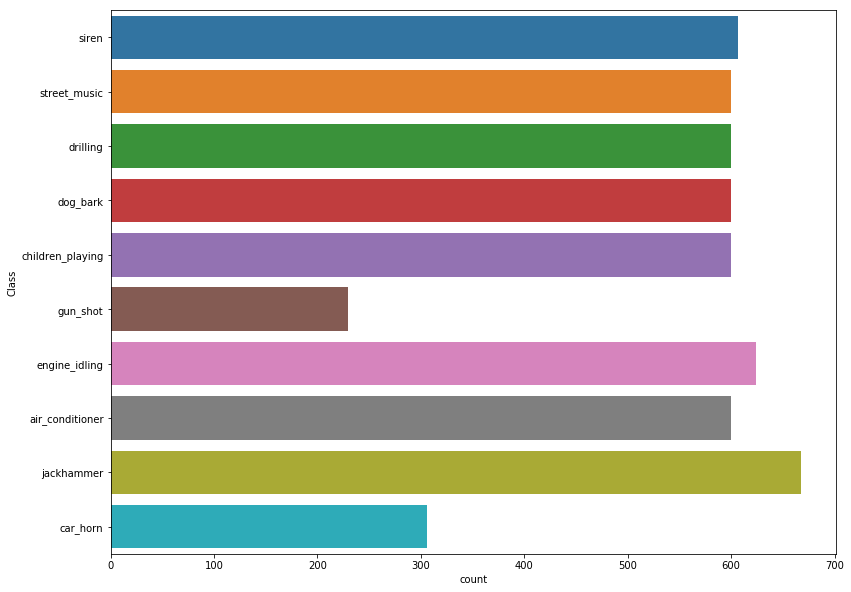

In [99]:
classDistribution = classification.groupby(['Class']).count().reset_index().rename(columns={'ID':'Count'})
plt.figure(figsize=(13,10))
p = sns.countplot(data=data,y='Class')


`Gun Shot` and `Car Horn` categories are underpopulated. We could: 

* digitize and upsample these categories
* downsample all categories
* add more labeled observations to the smaller categories
* leave as is hoping that the categories with the smaller population stil have enough to train the network

Let's leave the data intact. If during the training we realize that the scarsly popluated categories are not detected well we will take action

### Basic Data Stats

Let's explore the sound smaples in depth. Knowning the sample duration ,sample, rate, number of channels, ec. will help us to understnad what the data normalization and prepration must be done prior to feeding the data to a model. We start with the extraction of sound characteristics of each sample...  

In [112]:
# take file nmes of all files
paths = glob.glob("{0}/samples/*".format(TRAIN_DATA_PATH))
# parse the sound file metad data. It takes a few second
tmp = [sf.SoundFile(path) for path in paths]
# attributes of interest
attributes = ['name', 'channels','samplerate','frames','format','subtype']
df = pd.DataFrame( [{fn: getattr(f, fn) for fn in attributes} for f in tmp])
#df.columns=['Path','Channels','SampleRate','Frames','Format','SubType']
df.rename(columns={'name':'Path', 'channels':'Channels','samplerate':'SampleRate','frames':'Frames','format':'Format',
    'subtype':'SubType'}, inplace=True)
df.head()

,Channels,Format,Frames,Path,SampleRate,SubType
0,2,WAV,176400,../data/original/train/samples\0.wav,44100,PCM_16
1,1,WAV,192000,../data/original/train/samples\1.wav,48000,PCM_16
2,2,WAV,176400,../data/original/train/samples\10.wav,44100,PCM_16
3,2,WAV,176400,../data/original/train/samples\100.wav,44100,PCM_16
4,2,WAV,176400,../data/original/train/samples\1000.wav,44100,PCM_16


Next we merge classification dataframe with the dataframe that contains the sound metrics.

In [113]:
df= pd.concat([classification,df], axis=1)

In [114]:
df.head()

,ID,Class,Channels,Format,Frames,Path,SampleRate,SubType
0,0,siren,2,WAV,176400,../data/original/train/samples\0.wav,44100,PCM_16
1,1,street_music,1,WAV,192000,../data/original/train/samples\1.wav,48000,PCM_16
2,2,drilling,2,WAV,176400,../data/original/train/samples\10.wav,44100,PCM_16
3,3,siren,2,WAV,176400,../data/original/train/samples\100.wav,44100,PCM_16
4,4,dog_bark,2,WAV,176400,../data/original/train/samples\1000.wav,44100,PCM_16


#### Sample Rate Distirbution

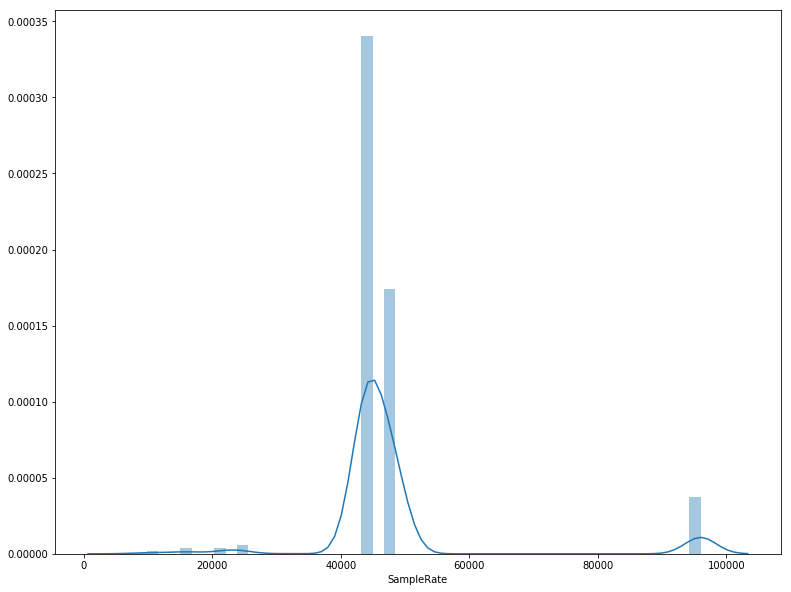

In [116]:
plt.figure(figsize=(13,10))
sns.distplot(df.SampleRate);

Evidently the sample rate of the sound files varies. We would have to resample the original data to bring it to the same standard. Let's caclulate the length of the sounds

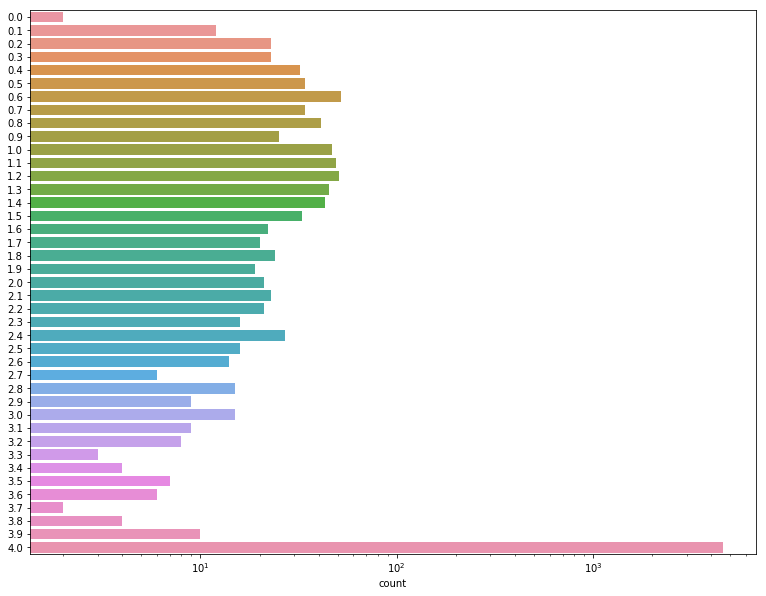

In [119]:
plt.figure(figsize=(13,10))
sns.countplot(y=round(df.Frames/df.SampleRate,1), log=True);

Majority of the sound files are 4 second long. But there are some file that are less than s second long. Design the network we would have to make sure that the input layer is able to deal with the sound samples of various length and a sample rate. Lastly we are going to verify if all the samples were recorded in stereo.


#### Sound Characteristics of Each Category 

There are ten sound classess. Let's taka a sample from each class and review its characteristics. WORK in progress!!

In [ ]:
p = "{0}/samples/66.wav".format(TRAIN_DATA_PATH)
siren, r = sf.read(p)
sfl = sf.SoundFile(p)
#street_music
#drilling
#dog_bark
#children_playing
#gun_shot
#engine_idling
#air_conditioner
#jackhammer
#car_horn

In [63]:
print("Sound File: {0}, Channels: {1} Format: {2} Rate: {3} Frames: {4} Length: {5}".format(sfl.name,
sfl.channels,sfl.format,sfl.samplerate, sfl.frames,round(sfl.samplerate/sfl.samplerate,2)  ))

Sound File: ../data/original/train/samples/66.wav, Channels: 2 Format: WAVEX Rate: 96000 Frames: 384000 Length: 1.0


In [ ]:
plt.figure(figsize=(13,10))
p=librosa.display.waveplot(siren,sr=r)

In [ ]:
from scipy.io import wavfile
rate, data = wavfile.read(p)

In [ ]:
IPython.display.Audio(data=siren,rate=r)

In [ ]:
#sr=44100, to_mono=True)
x, sr = librosa.load(p, sr=r)

In [ ]:
librosa.display.waveplot(x, sr=sr)

In [ ]:
x.shape

